<a href="https://www.kaggle.com/code/abukhadeejahkarl/imdb-data-playground?scriptVersionId=141478173" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os



#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#main media name dataset
tbasics_file = "/kaggle/input/imdb-basic-dataset/title.basics.tsv/data.tsv"
# TV show link table
eposode_file = "/kaggle/input/imdb-basic-dataset/title.episode.tsv/data.tsv"
# Big file, a linking dataset for film workers/acters to videos.  also lists jobs, category
principals_file = "/kaggle/input/imdb-basic-dataset/title.principals.tsv/data.tsv"
# ratings
ratings_file = "/kaggle/input/imdb-basic-dataset/title.ratings.tsv/data.tsv"
# Actors, Workers, people in credits
nbasics_file = "/kaggle/input/imdb-basic-dataset/name.basics.tsv/data.tsv"
# very big file; alternative names for movies. 
#  some Japanese or Chinese moves have different titles in different regions
#  ie - Shogun Assassian (US) and Lone Wolf and Cub (JP)
akas_file = "/kaggle/input/imdb-basic-dataset/title.akas.tsv/data.tsv"
# link dataset for media to directors and writers
crew_file = "/kaggle/input/imdb-basic-dataset/title.crew.tsv/data.tsv"

# IMDB Python Class

this will contain the logic for dealing with the IMDB data.

In [3]:
class IMDB:
    def __init__(self, tbasic, ratings):
        basics = pd.read_csv(tbasic, sep='\t', low_memory=False)
        ratings = pd.read_csv(ratings, sep='\t')
        self.tbasics = basics.join(ratings.set_index('tconst'), on="tconst").replace('\\N', np.nan)
        self.genres = []
        self.Videos = None
        self.TVShow = None

    def find_video(self, col, match):
        return self.Videos[col].str.contains(match).sum()

    def find_tv(self, col, match):
        return self.TVShow[col].str.contains(match).sum()

    def find_video_df(self, match):
        return None

    def find_tv_df(self, match):
        return None

    def titleTypeCount(self):
        return self.tbasics.groupby(['titleType']).titleType.count()

    def genres_imdb(self):
        if self.TVShow is not None:
            return self.TVShow.groupby(['genres']).titleType.count()
        elif self.Videos is not None:
            return self.Videos.groupby(['genres']).titleType.count()
        else:
            return self.tbasics.groupby(['genres']).titleType.count()

    # returns a count of each genre found
    def set_genres(self):
        cg = {}
        # reset
        self.genres = []
        if self.TVShow is not None:
            data = self.TVShow.genres.dropna()
        elif self.Videos is not None:
            data = self.Videos.genres.dropna()
        else:
            data = self.tbasics.genres.dropna()
        for x in data:
            for g in self.process_genres(x):
                if g not in self.genres:
                    self.genres.append(g)
                    cg[g] = 1
                else:
                    cg[g] = cg[g] + 1
        return cg

    def process_genres(self, g):
        return str(g).split(',')

    # Filter out the TV shows and episodes.

    def filter_tv(self):
        self.Videos = self.tbasics.loc[
            (self.tbasics['titleType'] != "tvSeries") & (self.tbasics['titleType'] != "tvEpisode")
        ].rename(columns={
            "startYear": "year",
            "runtimeMinutes":"minutes"
        }).drop(["endYear"], axis=1)

    def set_tvshows(self, episodes):
        # set \\N to zero hear since some TV databases have shows with season 0 and episode 0 for some specials
        e = pd.read_csv(episodes, sep='\t').rename(columns={
            "seasonNumber": "S",
            "episodeNumber": "E"
        }).replace('\\N', 0)

        self.TVShow = e.join(self.tbasics.drop([
            'isAdult',
            'runtimeMinutes',
            'genres',
            'titleType',
            'averageRating',
            'numVotes'
        ], axis=1).rename(columns={
            "tconst": "parentTconst",
            "primaryTitle": "TVShow"
        }).set_index('parentTconst'), on="parentTconst").join(self.tbasics.drop([
            "endYear"
        ], axis=1).rename(columns={
            "primaryTitle": "episodeTitle",
            "originalTitle": "originalEpisode",
            "startYear": "year",
            "runtimeMinutes": "minutes"
        }).set_index('tconst'), on="tconst").drop([
            'parentTconst'
        ], axis=1)




    # Get DataFrame filtered to titleType in the IMDB dataset
    # some videos/movies might have a title type you might not expect, like video instead of movie
    def get_tvMiniSeries(self):
        return self.tbasics.loc[(self.tbasics['titleType'] == "tvMiniSeries")]

    def get_tvSpecial(self):
        return self.tbasics.loc[(self.tbasics['titleType'] == "tvSpecial")]

    def get_tvPilot(self):
        return self.tbasics.loc[(self.tbasics['titleType'] == "tvPilot")]

    def get_video(self):
        return self.tbasics.loc[(self.tbasics['titleType'] == "video")]

    def get_tvPilot(self):
        return self.tbasics.loc[(self.tbasics['titleType'] == "videoGame")]

    # movies
    def get_tvMovie(self):
        return self.tbasics.loc[(self.tbasics['titleType'] == "tvMovie")]

    def get_movie(self):
        return self.tbasics.loc[(self.tbasics['titleType'] == "movie")]

    # shorts
    def get_tvShort(self):
        return self.tbasics.loc[(self.tbasics['titleType'] == "tvShort")]

    def get_short(self):
        return self.tbasics.loc[(self.tbasics['titleType'] == "short")]

# Load the main Media data set
this Dataset will contain all the videos that can be found on IMDB.  It is not limited to Movies and TV shows, you can also find fan films and podcasts too.  I enabled ```low_memory=False``` to suppress errors when loading the data.

In [4]:

# basics = pd.read_csv(tbasics_file, sep='\t', low_memory=False)


# Load ratings dataset
First I load the ratings dataset and join it with the Media dataset (basics).  Now every Media that is listed has a rating and votes listed in each row.

In [5]:
#ratings = pd.read_csv(ratings_file, sep='\t')

#tbasics = basics.join(ratings.set_index('tconst'), on="tconst")

IM = IMDB(tbasics_file, ratings_file)

# Lets view the updated Dataframe
The data now has the average rating and number of votes

In [6]:
#tbasics.head()
IM.tbasics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000001,short,Carmencita,Carmencita,0,1894,NaN,1,"Documentary,Short",5.7,1980.0
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,NaN,5,"Animation,Short",5.8,265.0
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,NaN,4,"Animation,Comedy,Romance",6.5,1835.0
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,NaN,12,"Animation,Short",5.6,179.0
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,NaN,1,"Comedy,Short",6.2,2624.0


# What is the break down of Media Type
as you will see bellow, their are a few different enteries with tv as a prefix. tvPilot only has 1.

In [7]:
#tbasics.groupby(['titleType']).titleType.count()
IM.tbasics.groupby(['titleType']).titleType.count()

titleType
movie            648082
short            935682
tvEpisode       7546405
tvMiniSeries      48929
tvMovie          142038
tvPilot               1
tvSeries         244950
tvShort            9968
tvSpecial         41988
video            275322
videoGame         34883
Name: titleType, dtype: int64

# let's look at the genres that are listed in IMDB

In [8]:
IM.genres_imdb()

genres
Action                    36653
Action,Adult                239
Action,Adult,Adventure       74
Action,Adult,Animation       93
Action,Adult,Comedy          44
                          ...  
Thriller,War,Western          3
Thriller,Western             43
War                        2874
War,Western                  11
Western                   12537
Name: titleType, Length: 2342, dtype: int64

# slimming down Genres list

bellow i process each value into a single genres.  most of the videos have multiple categories.

In [9]:
genres = pd.DataFrame.from_dict(IM.set_genres(), orient='index', columns=['videos']) 

In [10]:
genres

,videos
Documentary,934580
Short,1093703
Animation,507980
Comedy,1995134
Romance,927930
Sport,234864
News,871650
Drama,2813680
Fantasy,202983
Horror,177041


# Prepair the Data for TV series

This will transform the data for TV Shows into something a little more helpful. 2 new dataframes will need to be created, one for tvSeries and one for tvEpisode. 

- the episode dataset will link the 2 together
- column names of both sets will need to be renamed
- irrelivent columns will need to be dropped

the final result will be a list of TV shows with some of the following:
- Show name
- season number
- episode number
- episode name
- year of the episode 

In [11]:
# tvSeries = tbasics.loc[(tbasics['titleType'] == "tvSeries")].rename(columns={"tconst":"parentTconst", "primaryTitle":"TVShow"})
# tvEpisode = tbasics.loc[(tbasics['titleType'] == "tvEpisode")].rename(columns={"primaryTitle": "eposodeTitle", "originalTitle": "originalEposode", "startYear": "year", "runtimeMinutes":"minutes"})
# eposodes = pd.read_csv(eposode_file, sep='\t').rename(columns={"seasonNumber": "S", "episodeNumber": "E"})
# TV = eposodes.join(tvSeries.drop([
#        'isAdult','runtimeMinutes','genres','titleType','averageRating', 'numVotes'
#    ], axis=1).set_index('parentTconst'), on="parentTconst").join(tvEpisode.drop(['titleType',"endYear"], axis=1).set_index('tconst'), on="tconst").drop(['parentTconst'],axis=1)
IM.set_tvshows(eposode_file)

In [12]:
IM.TVShow.head()

,tconst,S,E,TVShow,originalTitle,startYear,endYear,titleType,episodeTitle,originalEpisode,isAdult,year,minutes,genres,averageRating,numVotes
0,tt0041951,1,9,The Lone Ranger,The Lone Ranger,1949,1957,tvEpisode,The Tenderfeet,The Tenderfeet,0,1949,30,Western,7.5,81.0
1,tt0042816,1,17,BBC Sunday-Night Theatre,BBC Sunday-Night Theatre,1950,1959,tvEpisode,Othello,Othello,0,1950,135,Drama,NaN,NaN
2,tt0042889,0,0,BBC Sunday-Night Theatre,BBC Sunday-Night Theatre,1950,1959,tvEpisode,The Tragedy of King Richard II/II,The Tragedy of King Richard II/II,0,1950,145,Drama,NaN,NaN
3,tt0043426,3,42,Studio One,Studio One,1948,1958,tvEpisode,Coriolanus,Coriolanus,0,1951,60,Drama,NaN,NaN
4,tt0043631,2,16,BBC Sunday-Night Theatre,BBC Sunday-Night Theatre,1950,1959,tvEpisode,The Life of King Henry V,The Life of King Henry V,0,1951,133,Drama,6.8,11.0


# Filter out TV Shows

This will have make a new DataFrame without "tvEpisode" or Show names
- rename columns to be shorter
- drop columns that are not needed

In [13]:
#Videos = tbasics.loc[tbasics.titleType != "tvEpisode"].rename(columns={"startYear": "year", "runtimeMinutes":"minutes", "averageRating":"rating", "numVotes":"votes"}).drop(["endYear", "isAdult"], axis=1)
IM.filter_tv()
IM.Videos

,tconst,titleType,primaryTitle,originalTitle,isAdult,year,minutes,genres,averageRating,numVotes
0,tt0000001,short,Carmencita,Carmencita,0,1894,1,"Documentary,Short",5.7,1980.0
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,5,"Animation,Short",5.8,265.0
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,4,"Animation,Comedy,Romance",6.5,1835.0
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,12,"Animation,Short",5.6,179.0
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,1,"Comedy,Short",6.2,2624.0
...,...,...,...,...,...,...,...,...,...,...
9928188,tt9916730,movie,6 Gunn,6 Gunn,0,2017,116,NaN,8.3,10.0
9928198,tt9916754,movie,Chico Albuquerque - Revelações,Chico Albuquerque - Revelações,0,2013,49,Documentary,NaN,NaN
9928199,tt9916756,short,Pretty Pretty Black Girl,Pretty Pretty Black Girl,0,2019,NaN,Short,NaN,NaN
9928203,tt9916764,short,38,38,0,2018,NaN,Short,NaN,NaN


# Lets look at the ratings of Star Wars
I was 5-6 when I first saw a New Hope and Empire Strikes Back.  I also read a lot of the legacy books when I was in grade 8.  lots of memories

In [14]:
SW = IM.Videos.loc[ IM.Videos["primaryTitle"].str.contains("Star Wars") & (IM.Videos['titleType'] == 'movie') & (IM.Videos['numVotes'] > 1024)].dropna().drop(columns=['titleType', 'originalTitle', 'isAdult']).sort_values(by='year')
SW

,tconst,primaryTitle,year,minutes,genres,averageRating,numVotes
75150,tt0076759,Star Wars: Episode IV - A New Hope,1977,121,"Action,Adventure,Fantasy",8.6,1395759.0
78966,tt0080684,Star Wars: Episode V - The Empire Strikes Back,1980,124,"Action,Adventure,Fantasy",8.7,1323423.0
84310,tt0086190,Star Wars: Episode VI - Return of the Jedi,1983,131,"Action,Adventure,Fantasy",8.3,1079320.0
117973,tt0120915,Star Wars: Episode I - The Phantom Menace,1999,136,"Action,Adventure,Fantasy",6.5,825987.0
118695,tt0121765,Star Wars: Episode II - Attack of the Clones,2002,142,"Action,Adventure,Fantasy",6.6,730618.0
118696,tt0121766,Star Wars: Episode III - Revenge of the Sith,2005,140,"Action,Adventure,Fantasy",7.6,813140.0
2000701,tt1185834,Star Wars: The Clone Wars,2008,98,"Action,Adventure,Animation",5.9,69306.0
6137501,tt2488496,Star Wars: Episode VII - The Force Awakens,2015,138,"Action,Adventure,Sci-Fi",7.8,948346.0
7146268,tt3748528,Rogue One: A Star Wars Story,2016,133,"Action,Adventure,Sci-Fi",7.8,658838.0
6168620,tt2527336,Star Wars: Episode VIII - The Last Jedi,2017,152,"Action,Adventure,Fantasy",6.9,648706.0


<Axes: xlabel='Star Wars Movie Ratings'>

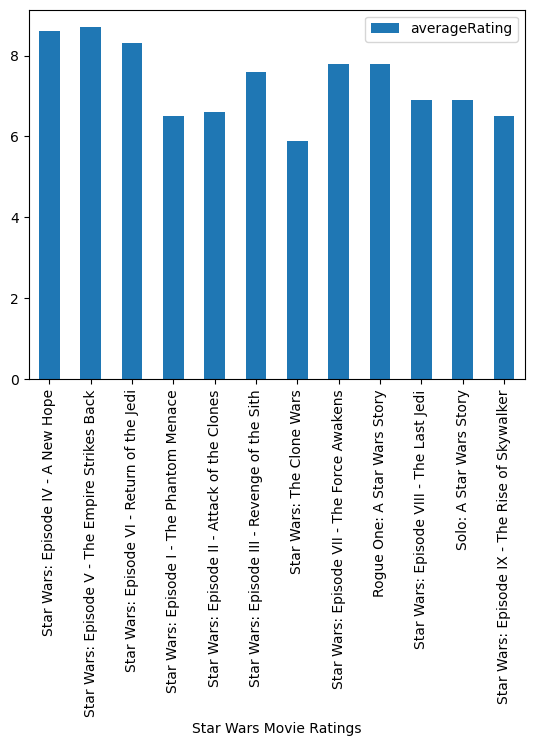

In [15]:
SW.plot.bar(x='primaryTitle', y='averageRating', xlabel="Star Wars Movie Ratings")

<Axes: xlabel='Votes for Star Wars Movies'>

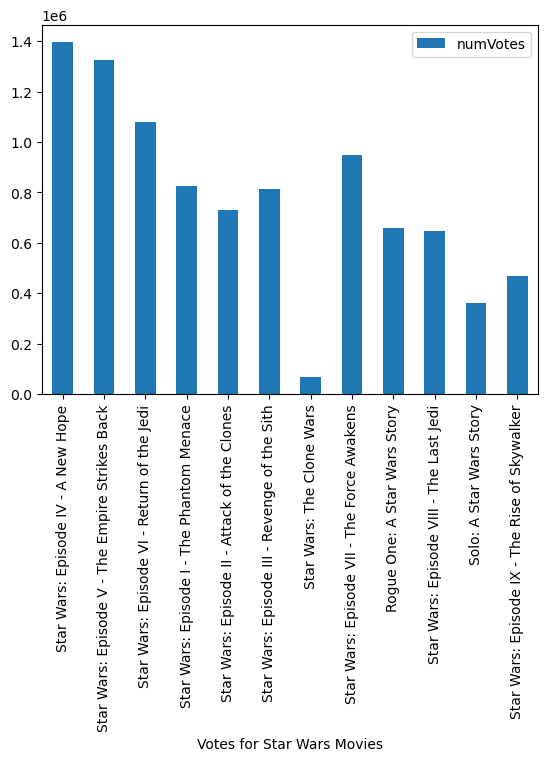

In [16]:
SW.plot.bar(x='primaryTitle', y='numVotes', xlabel="Votes for Star Wars Movies")

**the code bellow hasn't been added to the IMDB class above, it's still being worked on **

# Now I'm going to match actors with Videos

we need to read the principals and the nbasics first

In [17]:
principals = pd.read_csv(principals_file, sep='\t')
nbasics = pd.read_csv(nbasics_file, sep='\t')

# make DataFrame for Actors
List actors first, then the movie

In [18]:
Actors = principals.loc[(principals['category'] == "actor")].drop(['characters','ordering', 'category', 'job'], axis=1).join(nbasics.drop(['primaryProfession', 'knownForTitles'], axis=1).set_index('nconst'), on="nconst" ).sort_values(by=['primaryName']).dropna().rename(columns={"primaryName":"Actor"}).drop(['nconst'], axis=1)
Actors = Actors.join(IM.Videos.set_index('tconst'), on="tconst").dropna()


# Basic Actors table for Videos

In [19]:
Actors.head()

,tconst,Actor,birthYear,deathYear,titleType,primaryTitle,originalTitle,isAdult,year,minutes,genres,averageRating,numVotes
2759252,tt0383929,'Big' LeRoy Mobley,1973,\N,movie,Black August,Black August,0,2007,116,Drama,6.3,299.0
1218957,tt0148751,'Black Dog' Carter,\N,\N,movie,Breakdown,Breakdown,1,1974,59,Adult,5.4,15.0
42878325,tt4599232,'Blue' Gene Tyranny,1945,2020,tvMovie,Perfect Lives,Perfect Lives,0,1984,175,Musical,8.4,10.0
1363937,tt0170246,'Blues' McAllister,\N,\N,short,Mills Blue Rhythm Band,Mills Blue Rhythm Band,0,1934,11,"Music,Short",6.4,77.0
9690828,tt10642592,'Calamity Jane' Nemhauser,\N,\N,movie,Tattoo Uprising,Tattoo Uprising,0,2019,75,Documentary,6.5,38.0


# Acters list in IMDB for Star Wars

In [20]:
Actors.loc[(Actors['primaryTitle'].str.contains("Star Wars"))]

,tconst,Actor,birthYear,deathYear,titleType,primaryTitle,originalTitle,isAdult,year,minutes,genres,averageRating,numVotes
30901432,tt20784210,'Weird Al' Yankovic,1959,\N,tvSpecial,Lego Star Wars Summer Vacation,LEGO Star Wars Summer Vacation,0,2022,45,"Action,Adventure,Animation",5.6,1505.0
23151884,tt15164924,A.J. LoCascio,1987,\N,tvMovie,Lego Star Wars Terrifying Tales,Lego Star Wars Terrifying Tales,0,2021,44,"Action,Adventure,Animation",6.1,2516.0
16780547,tt12885438,A.J. LoCascio,1987,\N,tvMovie,The Lego Star Wars Holiday Special,The Lego Star Wars Holiday Special,0,2020,44,"Action,Adventure,Animation",6.4,7368.0
49650884,tt7439508,Aaron Liburd,\N,\N,short,Eternal: A Star Wars Fan Film,Eternal: A Star Wars Fan Film,0,2017,24,"Sci-Fi,Short",5.4,16.0
53733859,tt8921018,Abe Danz,\N,\N,short,TK630 - A Star Wars Fan Film,TK630 - A Star Wars Fan Film,0,2018,10,"Sci-Fi,Short",7.1,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41189754,tt3853894,Zak Koonce,\N,\N,video,The Friend Zone: Star Wars Ep2 - Auralnauts,STAR WARS EP 2: The Friend Zone,0,2013,18,"Comedy,Short",9.3,16.0
41189905,tt3853936,Zak Koonce,\N,\N,video,Revenge of Middle Management: Star Wars Ep3,STAR WARS EP 3: Revenge of Middle Management,0,2014,30,"Comedy,Short",9.2,8.0
41189680,tt3853868,Zak Koonce,\N,\N,video,Jedi Party: Star Wars Ep1 - Auralnauts,STAR WARS EP 1: Jedi Party,0,2013,14,"Comedy,Short",9.2,31.0
49194938,tt7267338,Zander Martin,\N,\N,short,Birth of a Monster: A Star Wars Story,"Star Wars: Tales of the Twin Suns, Episode One...",0,2019,21,"Sci-Fi,Short",7.8,86.0


# Several tables for selected Actors

we will look at 3 actors with long cariears in the movie business

- Samuel L. Jackson
- Jackie Chan
- Jean-Claude Van Damme

In [21]:
a = {}
a['slj'] = Actors.loc[(Actors['Actor'].str.contains("Samuel L. Jackson"))]
a['jc'] = Actors.loc[(Actors['Actor'].str.contains("Jackie Chan"))]
a['jcvd'] = Actors.loc[(Actors['Actor'].str.contains("Jean-Claude Van Damme"))]

In [22]:
a['slj'].head()

,tconst,Actor,birthYear,deathYear,titleType,primaryTitle,originalTitle,isAdult,year,minutes,genres,averageRating,numVotes
923505,tt0107659,Samuel L. Jackson,1948,\N,movie,Loaded Weapon 1,Loaded Weapon 1,0,1993,84,"Action,Comedy,Crime",6.2,49824.0
45621416,tt5804038,Samuel L. Jackson,1948,\N,movie,I Am Not Your Negro,I Am Not Your Negro,0,2016,93,"Documentary,History",7.9,22726.0
3448997,tt0486141,Samuel L. Jackson,1948,\N,video,Mr. Incredible and Pals,Mr. Incredible and Pals,0,2005,4,"Animation,Comedy,Family",6.5,925.0
1928340,tt0257076,Samuel L. Jackson,1948,\N,movie,S.W.A.T.,S.W.A.T.,0,2003,117,"Action,Adventure,Crime",6.0,151048.0
6814479,tt0914863,Samuel L. Jackson,1948,\N,movie,Unthinkable,Unthinkable,0,2010,97,"Crime,Drama,Thriller",7.0,90094.0


In [23]:
a['jc'].head()

,tconst,Actor,birthYear,deathYear,titleType,primaryTitle,originalTitle,isAdult,year,minutes,genres,averageRating,numVotes
684264,tt0080436,Jackie Chan,1954,\N,movie,Battle Creek Brawl,Battle Creek Brawl,0,1980,95,"Action,Comedy,Crime",5.7,5601.0
781678,tt0091427,Jackie Chan,1954,\N,movie,Heart of Dragon,Long de xin,0,1985,98,"Action,Comedy,Crime",6.3,4989.0
2771323,tt0386005,Jackie Chan,1954,\N,movie,New Police Story,San ging chaat goo si,0,2004,123,"Action,Crime,Thriller",6.9,28074.0
781718,tt0091431,Jackie Chan,1954,\N,movie,Armour of God,Lung hing foo dai,0,1986,88,"Action,Adventure,Comedy",6.9,20986.0
25444266,tt1615160,Jackie Chan,1954,\N,movie,The Foreigner,The Foreigner,0,2017,113,"Action,Thriller",7.0,118580.0


In [24]:
a['jcvd'].head()

,tconst,Actor,birthYear,deathYear,titleType,primaryTitle,originalTitle,isAdult,year,minutes,genres,averageRating,numVotes
27216779,tt1735862,Jean-Claude Van Damme,1960,\N,movie,Dragon Eyes,Dragon Eyes,0,2012,91,"Action,Crime,Drama",4.4,6190.0
981781,tt0114576,Jean-Claude Van Damme,1960,\N,movie,Sudden Death,Sudden Death,0,1995,111,"Action,Crime,Thriller",5.8,35870.0
857825,tt0100029,Jean-Claude Van Damme,1960,\N,movie,Lionheart,Lionheart,0,1990,108,"Action,Crime,Drama",6.2,37988.0
3293598,tt0462329,Jean-Claude Van Damme,1960,\N,video,The Hard Corps,The Hard Corps,0,2006,110,"Action,Thriller",5.2,6385.0
837048,tt0097659,Jean-Claude Van Damme,1960,\N,movie,Kickboxer,Kickboxer,0,1989,97,"Action,Sport,Thriller",6.4,58085.0


# Make a DF of Cinematographers


In [25]:
DOP = principals.loc[(principals['category'] == "cinematographer")].drop(['characters','ordering', 'category', 'job'], axis=1).join(nbasics.drop(['primaryProfession', 'knownForTitles'], axis=1).set_index('nconst'), on="nconst" ).sort_values(by=['primaryName']).dropna().rename(columns={"primaryName":"Crew"}).drop(['nconst'], axis=1)
DOP = DOP.join(IM.Videos.set_index('tconst'), on="tconst").dropna()


# This someone I work with in IATSE
- this is a list of Movies one of my co-workers has worked on.

In [26]:
DOP.loc[(DOP['Crew'].str.contains("John Holosko"))]

,tconst,Crew,birthYear,deathYear,titleType,primaryTitle,originalTitle,isAdult,year,minutes,genres,averageRating,numVotes
1348940,tt0167959,John Holosko,\N,\N,tvMovie,Giving Up the Ghost,Giving Up the Ghost,0,1998,96,"Comedy,Crime,Drama",5.9,79.0
2144903,tt0289758,John Holosko,\N,\N,movie,Phase IV,Phase IV,0,2002,103,"Action,Drama,Thriller",4.8,478.0
2249068,tt0305168,John Holosko,\N,\N,short,6ix,6ix,0,1999,11,"Comedy,Horror,Short",6.6,112.0
6784755,tt0910873,John Holosko,\N,\N,video,An Evening with Kevin Smith 2: Evening Harder,An Evening with Kevin Smith 2: Evening Harder,0,2006,239,"Comedy,Documentary",7.7,3131.0
12917839,tt1160750,John Holosko,\N,\N,tvSpecial,One x One Gala,One x One Gala,0,2007,93,Music,5.3,11.0
45470464,tt5738768,John Holosko,\N,\N,movie,Nursery Rhyme of a Madman,Nursery Rhyme of a Madman,0,2017,98,"Comedy,Crime,Drama",6.8,17.0
3025604,tt0423559,John Holosko,\N,\N,movie,"Ydessa, the Bears and etc...","Ydessa, les ours et etc...",0,2004,44,Documentary,7.1,407.0
2172173,tt0293664,John Holosko,\N,\N,movie,Treed Murray,Treed Murray,0,2001,90,"Drama,Thriller",7.2,1567.0
1019829,tt0119093,John Holosko,\N,\N,tvMovie,Face Down,Face Down,0,1997,97,"Crime,Drama,Mystery",5.5,224.0
1799212,tt0236823,John Holosko,\N,\N,movie,Undertaker,Undertaker,0,1996,107,"Action,Thriller",5.0,8.0
